# Assignment 2 - Machine Learning Project
### Project 1: Classify Images of Colon Cancer
### Group No. 3: Sheikh Abdul Munim (s4076159), Liya Benoy (s4027344)

- **Objective:**  To develop a machine learning system for a biomedical startup that accurately classifies 27x27 RGB histopathology images of colon cells into two key categories: cancerous vs. non-cancerous (Task 1) and cell-type classification (Task 2), including fibroblast, inflammatory, epithelial, and others, using a modified version of the CRCHistoPhenotypes dataset. The system should effectively leverage both labeled and semi-supervised learning approaches to maximize classification accuracy, improve generalization, and minimize diagnostic errors, while addressing challenges like class imbalance and patient-specific data leakage.
___

In [373]:
#importing required libraries
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import random
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense

In [374]:
#checking how many GPUs are available
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


In [375]:
#setting random seed
seed = 42 
random.seed(seed)

#setting seed for NumPy
np.random.seed(seed)

#setting seed for TensorFlow
tf.random.set_seed(seed)

#setting seed for full reproducibility (slower but stricter)
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [376]:
#importing the data labels (main dataset)
labels_main = pd.read_csv('Image_classification_data\data_labels_mainData.csv')
print("labels_main columns:")
labels_main.head()

labels_main columns:


,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [377]:
#importing the data labels (extra dataset)
labels_extra = pd.read_csv('Image_classification_data\data_labels_extraData.csv')
print("\nlabels_extra columns:")
labels_extra.head()


labels_extra columns:


,InstanceID,patientID,ImageName,isCancerous
0,12681,61,12681.png,0
1,12682,61,12682.png,0
2,12683,61,12683.png,0
3,12684,61,12684.png,0
4,12685,61,12685.png,0


In [378]:
#navigating to folder containing colon cell histopathology images
image_folder = 'Image_classification_data\patch_images'
images = os.listdir(image_folder)
print(f"Total Numer of Images: {len(images)}")

Total Numer of Images: 20280


In [379]:
#checking if there are extra images in images folder that are not given in data labels
images_set = set(images)
csv_images_set = set(labels_main['ImageName'].astype(str))  
print("Images in labels_main but missing from patch_images folder:", csv_images_set - images_set)
print("Images in patch_images folder but missing from labels_main:", images_set - csv_images_set)
#use only images that are listed in the CSV file
images_filtered = [img for img in images if img in csv_images_set]

Images in labels_main but missing from patch_images folder: set()
Images in patch_images folder but missing from labels_main: {'6175.png', '7576.png', '19785.png', '7400.png', '20772.png', '11115.png', '14992.png', '3693.png', '21836.png', '20768.png', '11455.png', '7498.png', '16346.png', '20765.png', '2500.png', '10317.png', '19164.png', '11535.png', '12757.png', '12810.png', '5146.png', '15085.png', '5275.png', '16324.png', '2361.png', '11701.png', '10266.png', '15569.png', '10963.png', '6678.png', '21750.png', '7661.png', '2541.png', '21540.png', '10741.png', '3704.png', '11166.png', '15289.png', '5961.png', '21587.png', '5271.png', '11461.png', '9690.png', '3740.png', '7228.png', '5444.png', '6086.png', '9850.png', '22199.png', '12497.png', '16369.png', '6059.png', '6072.png', '20908.png', '1877.png', '17666.png', '5935.png', '9681.png', '16132.png', '2087.png', '22051.png', '19469.png', '6154.png', '5124.png', '20668.png', '16288.png', '6991.png', '9713.png', '21517.png', '20720.

In [380]:
#defining function to load images
def load_images(image_folder, image_list):
    """Returns a dictionary mapping image names to PIL image objects."""
    images = {}
    for img_name in image_list:
        img_path = os.path.join(image_folder, img_name)
        try:
            with Image.open(img_path) as img:
                images[img_name] = img.copy()  
        except Exception as e:
            print(f"Error loading {img_name}: {e}")
    return images

#loading the images
image_objects = load_images(image_folder, labels_main['ImageName'])
#adding a new column 'Image' to labels_main
labels_main['Image'] = labels_main['ImageName'].map(image_objects)
labels_main.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous,Image
0,22405,1,22405.png,fibroblast,0,0,<PIL.Image.Image image mode=RGB size=27x27 at ...
1,22406,1,22406.png,fibroblast,0,0,<PIL.Image.Image image mode=RGB size=27x27 at ...
2,22407,1,22407.png,fibroblast,0,0,<PIL.Image.Image image mode=RGB size=27x27 at ...
3,22408,1,22408.png,fibroblast,0,0,<PIL.Image.Image image mode=RGB size=27x27 at ...
4,22409,1,22409.png,fibroblast,0,0,<PIL.Image.Image image mode=RGB size=27x27 at ...


___
# I. Exploratory Data Analysis (EDA)

In [381]:
#dimensions of data frame
labels_main.shape

(9896, 7)

In [382]:
#data types of columns
labels_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
 6   Image         9896 non-null   object
dtypes: int64(4), object(3)
memory usage: 541.3+ KB


In [383]:
#mapping 'cellType' to 'cellTypeName', ensuring mappings are consistent
unique_mappings = labels_main[['cellType', 'cellTypeName']].drop_duplicates()
unique_mappings

,cellType,cellTypeName
0,0,fibroblast
11,1,inflammatory
17,3,others
449,2,epithelial


In [384]:
#getting the number of unique values in each column
hashable_cols = [col for col in labels_main.columns if labels_main[col].map(lambda x: isinstance(x, (int, float, str, bool, type(None)))).all()]
#calculatting unique counts
unique_counts = labels_main[hashable_cols].nunique().sort_values(ascending=False)
print("Number of Unique Values per Column:")
print(unique_counts)

Number of Unique Values per Column:
InstanceID      9896
ImageName       9896
patientID         60
cellTypeName       4
cellType           4
isCancerous        2
dtype: int64


In [385]:
#displaying unique values and value counts for categorical variables found in last code chunk
categorical_cols = ['patientID', 'cellTypeName', 'cellType', 'isCancerous']
for col in categorical_cols:
    print(f"\nColumn: {col}")
    unique_vals = labels_main[col].nunique()
    print(f"Number of unique values: {unique_vals}")
    print("Unique Value Counts:")
    print(labels_main[col].value_counts().to_string())


Column: patientID
Number of unique values: 60
Unique Value Counts:
patientID
54    389
29    355
9     348
8     332
20    325
18    320
17    310
10    302
51    286
55    263
23    254
7     253
41    250
21    224
40    209
14    207
6     198
50    195
24    192
49    187
13    180
25    180
52    178
5     169
33    163
58    161
19    158
26    157
22    152
57    149
48    147
43    137
31    137
42    136
3     136
47    133
53    132
12    130
36    128
4     127
15    125
44    121
46    120
59    115
60    115
16    111
30    110
39    105
32     99
56     92
38     84
45     74
37     71
11     56
2      33
1      19
27     17
28     15
34     14
35     11

Column: cellTypeName
Number of unique values: 4
Unique Value Counts:
cellTypeName
epithelial      4079
inflammatory    2543
fibroblast      1888
others          1386

Column: cellType
Number of unique values: 4
Unique Value Counts:
cellType
2    4079
1    2543
0    1888
3    1386

Column: isCancerous
Number of unique va

In [386]:
#evaluation of numerical features within data set
labels_main.describe()

,InstanceID,patientID,cellType,isCancerous
count,9896.000000,9896.000000,9896.000000,9896.000000
mean,10193.880154,29.762025,1.501516,0.412187
std,6652.912660,17.486553,0.954867,0.492253
min,1.000000,1.000000,0.000000,0.000000
25%,4135.750000,14.000000,1.000000,0.000000
50%,9279.500000,26.000000,2.000000,0.000000
75%,16821.250000,47.000000,2.000000,1.000000
max,22444.000000,60.000000,3.000000,1.000000


In [387]:
#finding total number of images
images = os.listdir(image_folder)
print(f"Total Number of Images: {len(images)}")
#checking if there are extra images in images folder that are not given in data labels

images_set = set(images)
csv_images_set = set(labels_main['ImageName'].astype(str))  #no '.png' added
print("Number of Images in labels_main but missing from patch_images folder:", len(csv_images_set - images_set))
print("Number of Images in patch_images folder but missing from labels_main:", len(images_set - csv_images_set))

#use only images that are listed in the CSV file
images_filtered = [img for img in images if img in csv_images_set]

Total Number of Images: 20280
Number of Images in labels_main but missing from patch_images folder: 0
Number of Images in patch_images folder but missing from labels_main: 10384


In [388]:
#grouping by 'cellTypeName' and 'isCancerous', then counting the entries
cell_type_counts = labels_main.groupby(['cellTypeName', 'isCancerous']).size().unstack(fill_value=0)

#renamining the columns for clarity
cell_type_counts.columns = ['Non-Cancerous', 'Cancerous']
cell_type_counts

,Non-Cancerous,Cancerous
cellTypeName,,
epithelial,0,4079
fibroblast,1888,0
inflammatory,2543,0
others,1386,0


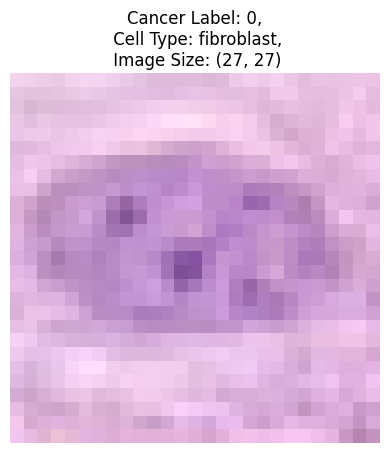

In [389]:
#fetching a single sample 
index = 0
sample = labels_main.iloc[index]
#extracting the image, cancer label, and cell type
img = sample['Image']  
cancer_label = sample['isCancerous']
cell_type = sample['cellTypeName']

if img:
    plt.imshow(img)
    plt.title(f"Cancer Label: {cancer_label},\n Cell Type: {cell_type},\n Image Size: {img.size}")
    plt.axis('off')  #hiding axes
    plt.show()
else:
    print("Error: Image not found.")

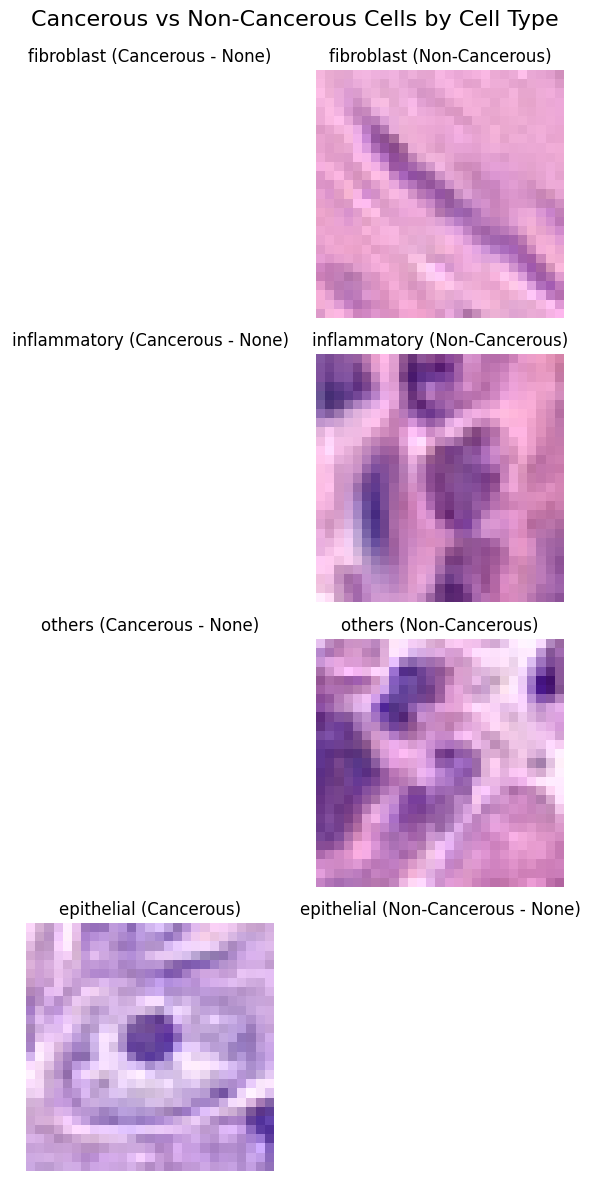

In [390]:
#getting unique cell types
cell_types = labels_main['cellTypeName'].dropna().unique()

fig, axes = plt.subplots(len(cell_types), 2, figsize=(6, 3 * len(cell_types)))

if len(cell_types) == 1:
    axes = np.expand_dims(axes, axis=0)

#filtering cancerous and non-cancerous data 
for i, cell_type in enumerate(cell_types):
    cancerous_df = labels_main[(labels_main['cellTypeName'] == cell_type) & 
                               (labels_main['isCancerous'] == 1)]
    non_cancerous_df = labels_main[(labels_main['cellTypeName'] == cell_type) & 
                                   (labels_main['isCancerous'] == 0)]
    
    #plotting cancerous image for cell type
    if not cancerous_df.empty:
        img = cancerous_df.sample(1).iloc[0]['Image']
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"{cell_type} (Cancerous)")
    else:
        axes[i, 0].set_title(f"{cell_type} (Cancerous - None)")
    axes[i, 0].axis('off')

    #plotting non-cancerous image for cell type
    if not non_cancerous_df.empty:
        img = non_cancerous_df.sample(1).iloc[0]['Image']
        axes[i, 1].imshow(img)
        axes[i, 1].set_title(f"{cell_type} (Non-Cancerous)")
    else:
        axes[i, 1].set_title(f"{cell_type} (Non-Cancerous - None)")
    axes[i, 1].axis('off')
    
#plotting comparison images
plt.suptitle('Cancerous vs Non-Cancerous Cells by Cell Type', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

Checking Image Quality: 100%|██████████| 9896/9896 [00:06<00:00, 1436.01it/s]



Summary of Image Quality Issues:
Total Blurry Images: 14
Total Occluded Images: 0

Results saved to 'image_quality_issues.csv'


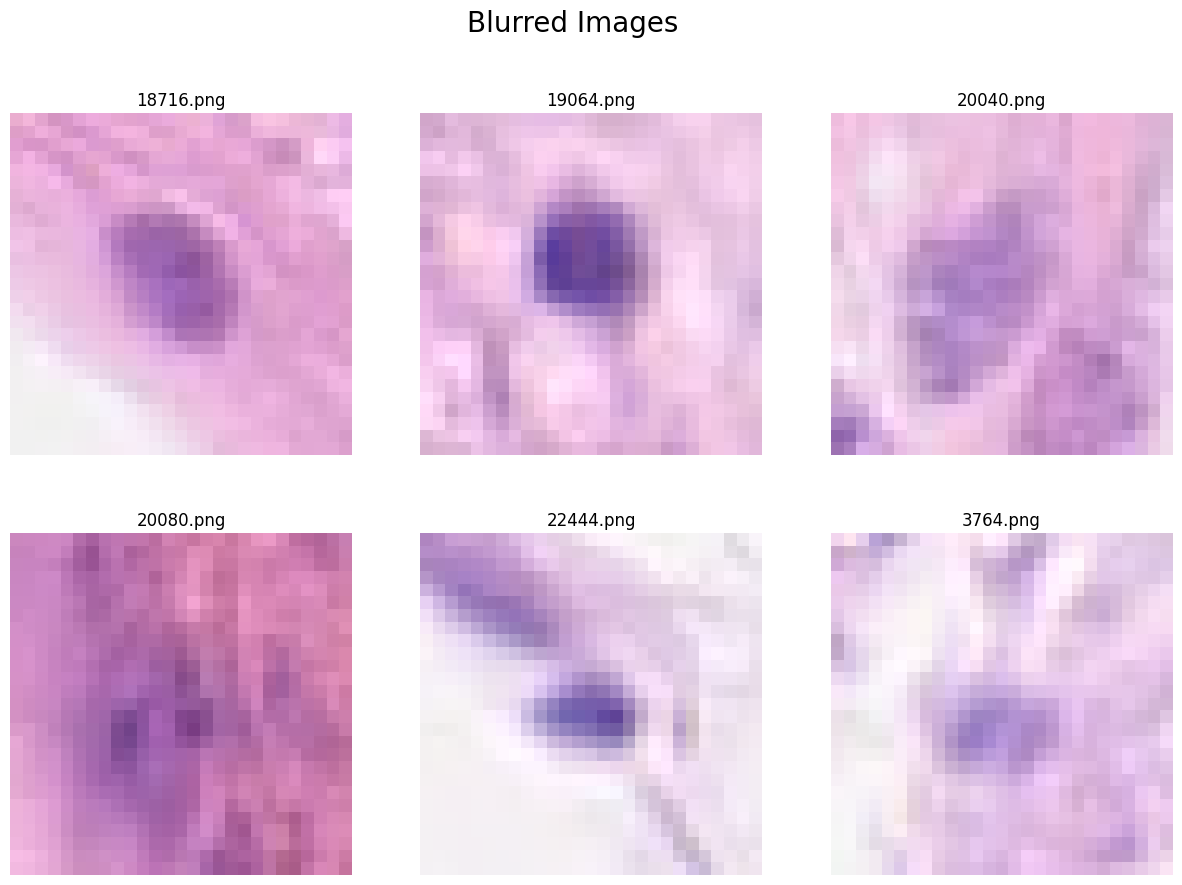

<Figure size 1500x1000 with 0 Axes>

In [391]:
import os
import cv2
import numpy as np
# import pytesseract
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
# Parameters for quality checks
BLUR_THRESHOLD = 500  # Lower is more blurry
OCCLUSION_EDGE_THRESHOLD = 1000  # Lower is more occluded
TEXT_THRESHOLD = 0.05  # Ratio of text area to total area

# Results
blurred_images = []
occluded_images = []
text_images = []

for img_name in tqdm(images_filtered, desc="Checking Image Quality"):
    img_path = os.path.join(image_folder, img_name)
    image = cv2.imread(img_path)

    # Check for blur
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
    if laplacian_var < BLUR_THRESHOLD:
        blurred_images.append(img_name)

    # Check for occlusion (simple edge count method)
    edges = cv2.Canny(gray, 100, 200)
    if np.sum(edges) < OCCLUSION_EDGE_THRESHOLD:
        occluded_images.append(img_name)

    # Check for embedded text
    # text = pytesseract.image_to_string(image)
    # if len(text.strip()) > 0:
    #     text_area = len(text.strip()) / (image.shape[0] * image.shape[1])
    #     if text_area > TEXT_THRESHOLD:
    #         text_images.append(img_name)

# Print summary
print("\nSummary of Image Quality Issues:")
print(f"Total Blurry Images: {len(blurred_images)}")
print(f"Total Occluded Images: {len(occluded_images)}")
# print(f"Total Images with Embedded Text: {len(text_images)}")

# Save results to CSV for further analysis
df_quality_issues = pd.DataFrame({
    "Blurred": pd.Series(blurred_images),
    "Occluded": pd.Series(occluded_images),
    # "Embedded_Text": pd.Series(text_images)
})

df_quality_issues.to_csv("image_quality_issues.csv", index=False)
print("\nResults saved to 'image_quality_issues.csv'")

# Visualization
def visualize_samples(image_list, title, n=6):
    plt.figure(figsize=(15, 10))
    for i, img_name in enumerate(image_list[:n]):
        img_path = os.path.join(image_folder, img_name)
        image = cv2.imread(img_path)
        plt.subplot(2, 3, i+1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(img_name)
        plt.axis('off')
    plt.suptitle(title, fontsize=20)
    plt.show()

# Show samples
visualize_samples(blurred_images, "Blurred Images")
visualize_samples(occluded_images, "Occluded Images")
# visualize_samples(text_images, "Images with Embedded Text")

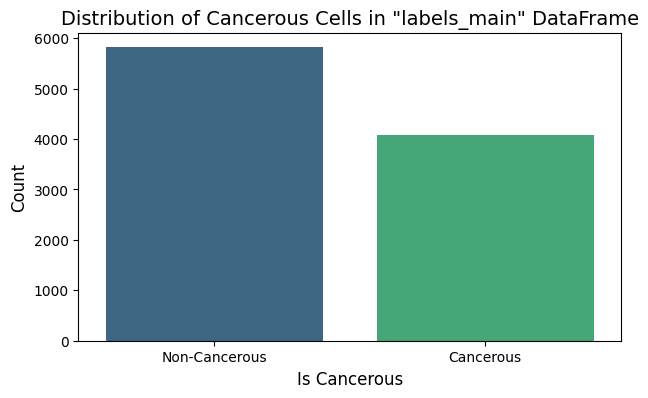

In [392]:
# Plotting the distribution of the 'isCancerous' label for checking class balance
plt.figure(figsize=(7, 4))
sns.countplot(data=labels_main, x='isCancerous', hue="isCancerous", palette='viridis', legend=False)
# Adding titles and labels
plt.title('Distribution of Cancerous Cells in "labels_main" DataFrame', fontsize=14)
plt.xlabel('Is Cancerous', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1], ['Non-Cancerous', 'Cancerous'])  
plt.show()

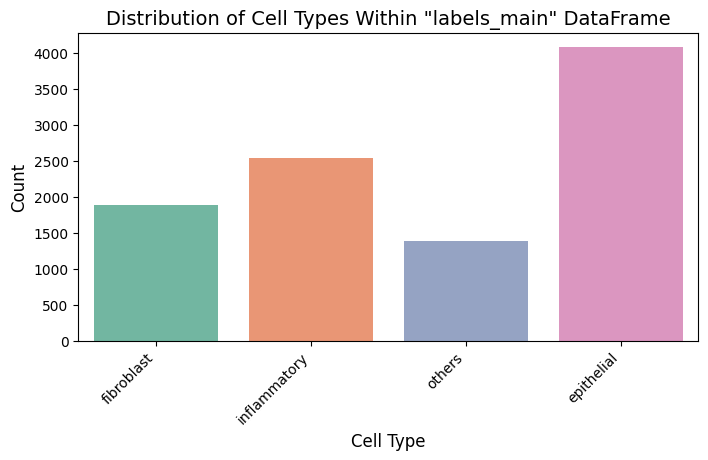

In [393]:
#plotting the distribution of the 'cellTypeName' label (consistent with 'cellType') for checking class balance
plt.figure(figsize=(8, 4))
sns.countplot(data=labels_main, x='cellTypeName', hue='cellTypeName', palette='Set2', legend=False)
plt.title('Distribution of Cell Types Within "labels_main" DataFrame', fontsize=14)
plt.xlabel('Cell Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
plt.show()

In [394]:
#checking for missing values in the entire DataFrame
missing_values = labels_main.isnull().sum()
#displaying the columns with missing values
print("Missing values in each column:")
print(missing_values)
missing_columns = missing_values[missing_values > 0]
print("\nColumns with missing values:")
print(missing_columns)

Missing values in each column:
InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
Image           0
dtype: int64

Columns with missing values:
Series([], dtype: int64)


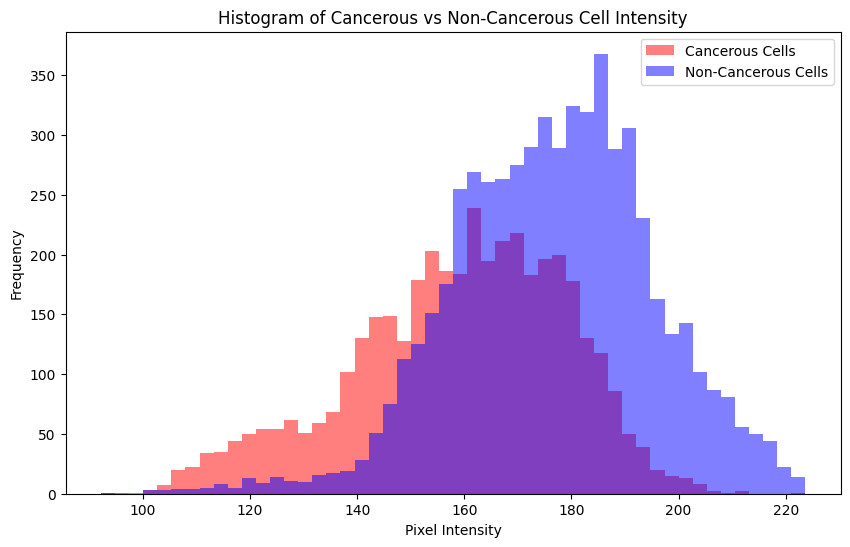

In [395]:
#defining function to calculate pixel intensity
def calculate_pixel_intensity(image_obj):
    img_gray = image_obj.convert('L') 
    #getting the pixel values as a numpy array
    pixel_values = np.array(img_gray)
    #calculating the average pixel intensity
    avg_intensity = pixel_values.mean()
    return avg_intensity

#filtering cancerous and non-cancerous cells from the DataFrame
cancerous_cells = labels_main[labels_main['isCancerous'] == 1].copy()
noncancerous_cells = labels_main[labels_main['isCancerous'] == 0].copy()

#applying the pixel intensity calculation function 
cancerous_cells.loc[:, 'pixel_intensity'] = cancerous_cells['Image'].apply(calculate_pixel_intensity)
noncancerous_cells.loc[:, 'pixel_intensity'] = noncancerous_cells['Image'].apply(calculate_pixel_intensity)

#extracting the pixel intensities as numpy arrays
cancerous_intensity = cancerous_cells['pixel_intensity'].values
noncancerous_intensity = noncancerous_cells['pixel_intensity'].values

#ensuring they are numpy arrays of floats for histogram calculation
cancerous_intensity = np.array(cancerous_intensity, dtype=float)
noncancerous_intensity = np.array(noncancerous_intensity, dtype=float)

#computing histograms
counts_cancer, bins = np.histogram(cancerous_intensity, bins=50)
counts_non_cancer, _ = np.histogram(noncancerous_intensity, bins=bins)

#plotting histograms
plt.figure(figsize=(10, 6))
plt.hist(cancerous_intensity, bins=bins, alpha=0.5, color='red', label='Cancerous Cells')
plt.hist(noncancerous_intensity, bins=bins, alpha=0.5, color='blue', label='Non-Cancerous Cells')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Histogram of Cancerous vs Non-Cancerous Cell Intensity')
plt.show()

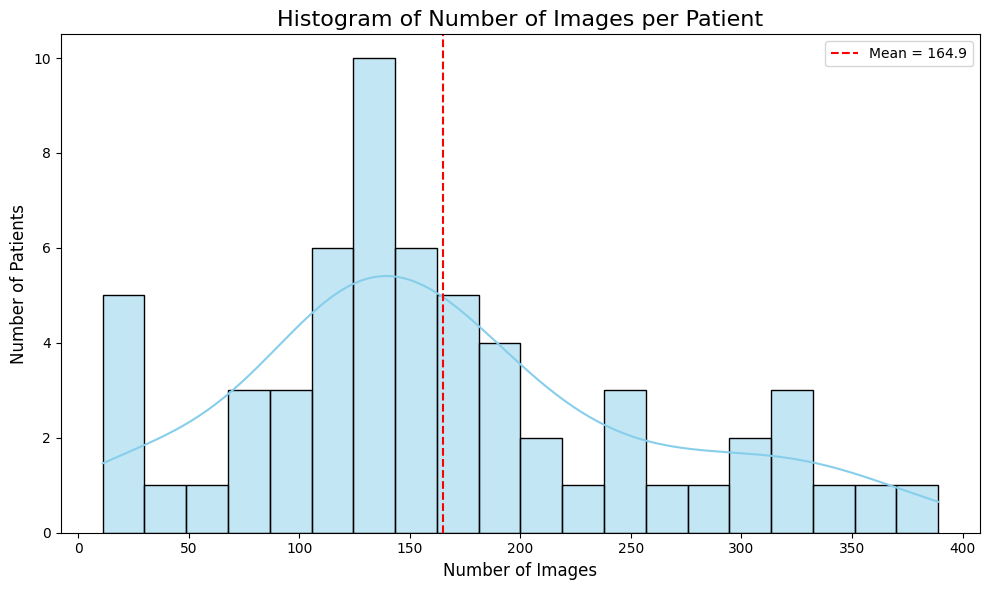

In [396]:
#counting the number of images per 'patientID'
patient_distribution = labels_main['patientID'].value_counts()
#plotting histogram
plt.figure(figsize=(10, 6))
sns.histplot(patient_distribution, bins=20, kde=True, color='skyblue')
#plotting mean line
mean_val = patient_distribution.mean()
plt.axvline(mean_val, color='red', linestyle='--', label=f'Mean = {mean_val:.1f}')
plt.title('Histogram of Number of Images per Patient', fontsize=16)
plt.xlabel('Number of Images', fontsize=12)
plt.ylabel('Number of Patients', fontsize=12) #number of patients that fall within each range
plt.legend()
plt.tight_layout()
plt.show()

## 1. Approach

### 1.1 Data Exploration and Understanding

- **Class Imbalance Identification:** 
The isCancerous label in the labels_main dataset shows a moderate imbalance, with 5,817 non-cancerous and 4,079 cancerous samples, roughly a 60:40 split. This imbalance can lead the model to favor non-cancerous predictions, reducing recall for cancerous cases, which is critical in medical diagnostics. Similarly, the cellTypeName distribution reveals a significant imbalance, with epithelial cells being nearly twice as common as the next most frequent class, inflammatory. This dominance increases the risk of overfitting and data leakage, as models might overly rely on this relationship for cancer predictions. To address this, techniques like class weighting, focal loss, and resampling are required to improve the model’s ability to generalize across all classes.

- **Exploratory Data Analysis:**
 The visual samples reveal key insights about the colon cell histopathology dataset. The first set of images shows that they are 27x27 samples for different cell types and cancer labels, confirming dimensions. The histogram of image intensity highlights significant pixel intensity differences between cancerous and non-cancerous cells, with cancerous cells generally having lower pixel intensities, peaking around 160, while non-cancerous cells peak around 180. This intensity difference can serve as a predictive feature for classification.
 The quality check identified 14 blurry images out of 9,896, with no occluded images or embedded text detected, as the BLUR_THRESHOLD was set to 500, and OCCLUSION_EDGE_THRESHOLD to 1000. These blurred images, like the samples provided, can introduce noise during training, reducing model accuracy if not handled properly.

- **Justification of Data Handling Methods:** 
The preprocessing steps included resizing images to 27x27 pixels to ensure consistent input dimensions, even though the originals were already this size, minimizing shape mismatch risks. Normalization to the [0, 1] range was applied to stabilize training by reducing brightness variation and improving gradient flow. Labels from labels_main and labels_extra were combined to enhance training diversity for just binary classification, though this step is optional if the extra data quality is uncertain. Finally, exception handling was included to skip corrupted images, ensuring smoother model training. Adding to this encoding has been applied to convert categorical data into numerical data. All the code are below.


___
## II. Data Pre-processing

In [397]:
"""    
The following code loads the images, resizes them to 27x27 pixels, normalizes the pixel values, and prepares the labels for CNN training.
The code also combines the labels from the main and extra detasets, however if you do not want to use the extra dataset, you can comment out the lines that load and concate the extra dataset.
The code also handles exceptions while loading images and prints the final shapes of the image dataset and labels.

"""
#lists to store the data
X_task1 = []
y_isCancerous = []
X_task2 = []
y_cellType = []

#combining only the isCancerous labels for Task 1
labels_task1 = pd.concat([labels_main, labels_extra], ignore_index=True)
#using only main labels for Task 2 (cellType)
labels_task2 = labels_main.copy()

#building separate dictionaries for fast lookup
labels_dict_task1 = labels_task1.set_index('ImageName').to_dict('index')
labels_dict_task2 = labels_task2.set_index('ImageName').to_dict('index')

#preparing list of all image names to be loaded (main + extra)
all_image_names = set(labels_task1['ImageName'])  # includes both main and extra

#loading and preprocess images
for img_name in all_image_names:
    try:
        img_path = os.path.join(image_folder, img_name)
        img = Image.open(img_path)
        img = img.resize((27, 27))  #ensuring all images are 27x27
        img_array = np.array(img) / 255.0  #normalize pixel values (0-1)
        #adding to Task 1 (isCancerous)
        if img_name in labels_dict_task1:
            X_task1.append(img_array)
            y_isCancerous.append(labels_dict_task1[img_name]['isCancerous'])
        #adding to Task 2 (cellType) only if it has a cellType label
        if img_name in labels_dict_task2:
            X_task2.append(img_array)
            y_cellType.append(labels_dict_task2[img_name]['cellType'])  
    except Exception as e:
        print(f"Error processing {img_name}: {e}")

#converting to numpy arrays
X_task1 = np.array(X_task1)
y_isCancerous = np.array(y_isCancerous)
X_task2 = np.array(X_task2)
y_cellType = np.array(y_cellType)

#printing shapes of resulting target and predictor features
print(f"Task 1 (isCancerous) - X shape: {X_task1.shape}, y shape: {y_isCancerous.shape}")
print(f"Task 2 (cellType) - X shape: {X_task2.shape}, y shape: {y_cellType.shape}")

Task 1 (isCancerous) - X shape: (20280, 27, 27, 3), y shape: (20280,)
Task 2 (cellType) - X shape: (9896, 27, 27, 3), y shape: (9896,)


In [398]:
#encoding for task 1
y_isCancerous = np.array(y_isCancerous) #converting to NumPy array to make it compatible with ML libraries
print(f"Task 1 (isCancerous) labels:\n {y_isCancerous}") #it is already binary so no need to encode

#encoding for task 2
le = LabelEncoder() #initialize label encoder
#integer encoding
y_cellType_encoded = le.fit_transform(y_cellType)
#one-hot encoding for multiclass classification
y_cellType_encoded = to_categorical(y_cellType_encoded)
print(f"\nTask 2 (cellType) labels after encoding:\n {y_cellType_encoded}")

#checking values after encoding
print(f"\nCell type classes: {le.classes_}")

Task 1 (isCancerous) labels:
 [0 0 1 ... 1 0 1]

Task 2 (cellType) labels after encoding:
 [[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 ...
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]]

Cell type classes: [0 1 2 3]


In [399]:
#preserving encoding order for future reference

#storing the classes for later use
cell_type_classes = le.classes_

#saving this to a file for reuse
np.save("cell_type_classes.npy", cell_type_classes)
print("Cell Type Classes (Preserved):", cell_type_classes)

#load the saved classes (when needed)
loaded_classes = np.load("cell_type_classes.npy")
print("Loaded Cell Type Classes:", loaded_classes)

Cell Type Classes (Preserved): [0 1 2 3]
Loaded Cell Type Classes: [0 1 2 3]


In [400]:
#saving data for label mappings for later use
cell_type_mapping = dict(zip(le.classes_, range(len(le.classes_))))
print("Cell Type Mapping:", cell_type_mapping)

#final check on data shapes
print(f"Final X_task1 shape: {X_task1.shape}")
print(f"Final y_isCancerous shape: {y_isCancerous.shape}")
print(f"Final X_task2 shape: {X_task2.shape}")
print(f"Final y_cellType_encoded shape: {y_cellType_encoded.shape}")

Cell Type Mapping: {0: 0, 1: 1, 2: 2, 3: 3}
Final X_task1 shape: (20280, 27, 27, 3)
Final y_isCancerous shape: (20280,)
Final X_task2 shape: (9896, 27, 27, 3)
Final y_cellType_encoded shape: (9896, 4)


Sample image shape: (27, 27, 3)


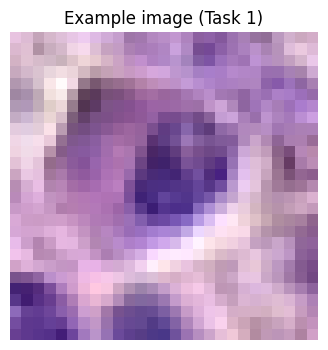

In [401]:
#checking image shapes and sample images after normalization and before splitting
print("Sample image shape:", X_task1[0].shape)
plt.figure(figsize=(4,4))
plt.imshow(X_task1[0])
plt.title("Example image (Task 1)")
plt.axis('off')
plt.show()

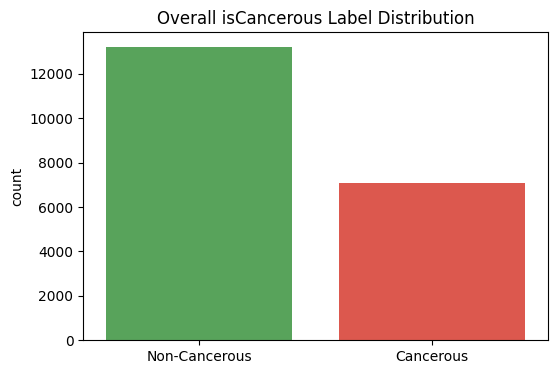

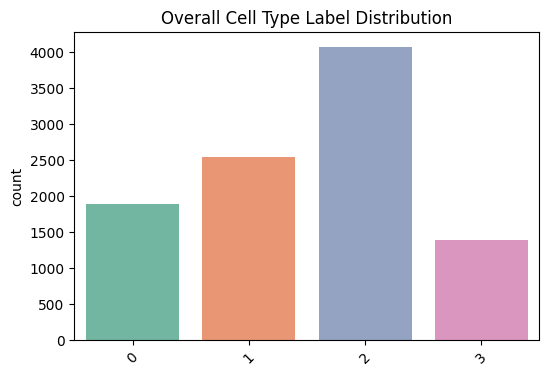

In [402]:
#checking the distribution of label before splitting data and after merging datasets and 
#Task 1: Binary 'isCancerous' distribution
plt.figure(figsize=(6,4))
sns.countplot(x=y_isCancerous, hue=y_isCancerous, palette=['#4CAF50', '#F44336'], legend=False)
plt.title("Overall isCancerous Label Distribution")
plt.xticks([0,1], ['Non-Cancerous', 'Cancerous'])
plt.show()
#Task 2: Multi-class 'cellType' distribution
y_cellType_int = np.argmax(y_cellType_encoded, axis=1)
plt.figure(figsize=(6,4))
sns.countplot(x=y_cellType_int, hue=y_cellType_int, palette=sns.color_palette("Set2", len(cell_type_classes)), legend=False)
plt.title("Overall Cell Type Label Distribution")
plt.xticks(ticks=range(len(cell_type_classes)), labels=cell_type_classes, rotation=45)
plt.show()

In [403]:
"""    
The following code loads the images, resizes them to 27x27 pixels, normalizes the pixel values, and prepares the labels for CNN training.
The code also combines the labels from the main and extra detasets, however if you do not want to use the extra dataset, you can comment out the lines that load and concate the extra dataset.
The code also handles exceptions while loading images and prints the final shapes of the image dataset and labels.

"""
#lists to store the data
X_task1 = []
y_isCancerous = []
X_task2 = []
y_cellType = []

#combining only the isCancerous labels for Task 1
labels_task1 = pd.concat([labels_main, labels_extra], ignore_index=True)
#using only main labels for Task 2 (cellType)
labels_task2 = labels_main.copy()

#building separate dictionaries for fast lookup
labels_dict_task1 = labels_task1.set_index('ImageName').to_dict('index')
labels_dict_task2 = labels_task2.set_index('ImageName').to_dict('index')

#preparing list of all image names to be loaded (main + extra)
all_image_names = set(labels_task1['ImageName'])  # includes both main and extra

#loading and preprocess images
for img_name in all_image_names:
    try:
        img_path = os.path.join(image_folder, img_name)
        img = Image.open(img_path)
        img = img.resize((27, 27))  #ensuring all images are 27x27
        img_array = np.array(img) / 255.0  #normalize pixel values (0-1)
        #adding to Task 1 (isCancerous)
        if img_name in labels_dict_task1:
            X_task1.append(img_array)
            y_isCancerous.append(labels_dict_task1[img_name]['isCancerous'])
        #adding to Task 2 (cellType) only if it has a cellType label
        if img_name in labels_dict_task2:
            X_task2.append(img_array)
            y_cellType.append(labels_dict_task2[img_name]['cellType'])  
    except Exception as e:
        print(f"Error processing {img_name}: {e}")

#converting to numpy arrays
X_task1 = np.array(X_task1)
y_isCancerous = np.array(y_isCancerous)
X_task2 = np.array(X_task2)
y_cellType = np.array(y_cellType)

#printing shapes of resulting target and predictor features
print(f"Task 1 (isCancerous) - X shape: {X_task1.shape}, y shape: {y_isCancerous.shape}")
print(f"Task 2 (cellType) - X shape: {X_task2.shape}, y shape: {y_cellType.shape}")

Task 1 (isCancerous) - X shape: (20280, 27, 27, 3), y shape: (20280,)
Task 2 (cellType) - X shape: (9896, 27, 27, 3), y shape: (9896,)


In [404]:
#encoding for task 1
y_isCancerous = np.array(y_isCancerous) #converting to NumPy array to make it compatible with ML libraries
print(f"Task 1 (isCancerous) labels:\n {y_isCancerous}") #it is already binary so no need to encode

#encoding for task 2
le = LabelEncoder() #initialize label encoder
#integer encoding
y_cellType_encoded = le.fit_transform(y_cellType)
#one-hot encoding for multiclass classification
y_cellType_encoded = to_categorical(y_cellType_encoded)
print(f"\nTask 2 (cellType) labels after encoding:\n {y_cellType_encoded}")

#checking values after encoding
print(f"\nCell type classes: {le.classes_}")

Task 1 (isCancerous) labels:
 [0 0 1 ... 1 0 1]

Task 2 (cellType) labels after encoding:
 [[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 ...
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]]

Cell type classes: [0 1 2 3]


In [405]:
#preserving encoding order for future reference

#storing the classes for later use
cell_type_classes = le.classes_

#saving this to a file for reuse
np.save("cell_type_classes.npy", cell_type_classes)
print("Cell Type Classes (Preserved):", cell_type_classes)

#load the saved classes (when needed)
loaded_classes = np.load("cell_type_classes.npy")
print("Loaded Cell Type Classes:", loaded_classes)

Cell Type Classes (Preserved): [0 1 2 3]
Loaded Cell Type Classes: [0 1 2 3]


In [406]:
#saving data for label mappings for later use
cell_type_mapping = dict(zip(le.classes_, range(len(le.classes_))))
print("Cell Type Mapping:", cell_type_mapping)

#final check on data shapes
print(f"Final X_task1 shape: {X_task1.shape}")
print(f"Final y_isCancerous shape: {y_isCancerous.shape}")
print(f"Final X_task2 shape: {X_task2.shape}")
print(f"Final y_cellType_encoded shape: {y_cellType_encoded.shape}")

Cell Type Mapping: {0: 0, 1: 1, 2: 2, 3: 3}
Final X_task1 shape: (20280, 27, 27, 3)
Final y_isCancerous shape: (20280,)
Final X_task2 shape: (9896, 27, 27, 3)
Final y_cellType_encoded shape: (9896, 4)


In [407]:
"""Since it is a patient-based dataset, splitting randomly may lead to data leakages, to tacke this, we will split the data based on patient IDs.
    The training, validation, and testing sets has split ratios of 80%, 10%, and 10% respectively.
    For the splitting stratified sampling is used to ensure that the distribution of the labels is similar in all sets.
    The strafication is done based on patient IDs, so that all images from a single patient are in the same set.
"""
#extracting 'patientID' from the dataset for each task
patient_ids_task1 = labels_task1['patientID']
patient_ids_task2 = labels_task2['patientID']
#getting unique patient IDs
unique_patients_task1 = np.unique(patient_ids_task1)
unique_patients_task2 = np.unique(patient_ids_task2)
#printing unqiue patients per task
print(f"Unique patients in Task 1: {len(unique_patients_task1)}")
print(f"Unique patients in Task 2: {len(unique_patients_task2)}")


#getting unique patients with their labels
patient_labels_1 = labels_task1[['patientID', 'isCancerous']].drop_duplicates()

#first split: 80% train, 20% temp (val + test)
train_patients_1, temp_patients_1 = train_test_split(
    patient_labels_1,
    test_size=0.2,
    stratify=patient_labels_1['isCancerous'],
    random_state=42
)

#second split: 50/50 of temp => 10% val, 10% test
val_patients_1, test_patients_1 = train_test_split(
    temp_patients_1,
    test_size=0.5,
    stratify=temp_patients_1['isCancerous'],
    random_state=42
)

# Convert to sets for lookup
train_patients_task1 = set(train_patients_1['patientID'])
val_patients_task1 = set(val_patients_1['patientID'])
test_patients_task1 = set(test_patients_1['patientID'])

#assigning a single label per patient by taking the dominant cellType
dominant_celltype_per_patient = labels_task2.groupby('patientID')['cellType'] \
    .agg(lambda x: x.value_counts().idxmax()) \
    .reset_index()

#first split: 80% train, 20% temp (val + test)
train_patients_2, temp_patients_2 = train_test_split(
    dominant_celltype_per_patient,
    test_size=0.2,
    stratify=dominant_celltype_per_patient['cellType'],
    random_state=42
)

#second split: 50/50 temp => 10% val, 10% test
val_patients_2, test_patients_2 = train_test_split(
    temp_patients_2,
    test_size=0.5,
    stratify=temp_patients_2['cellType'],
    random_state=42
)

# Convert to sets for lookup
train_patients_task2 = set(train_patients_2['patientID'])
val_patients_task2 = set(val_patients_2['patientID'])
test_patients_task2 = set(test_patients_2['patientID'])


#grouping images by 'patientID'

#Task 1 (isCancerous)
X_train_task1, y_train_task1 = [], []
X_val_task1, y_val_task1 = [], []
X_test_task1, y_test_task1 = [], []

for i, img in enumerate(X_task1):
    patient_id = labels_task1.iloc[i]['patientID']
    if patient_id in train_patients_task1:
        X_train_task1.append(img)
        y_train_task1.append(y_isCancerous[i])
    elif patient_id in val_patients_task1:
        X_val_task1.append(img)
        y_val_task1.append(y_isCancerous[i])
    elif patient_id in test_patients_task1:
        X_test_task1.append(img)
        y_test_task1.append(y_isCancerous[i])

#Task 2 (cellType)
X_train_task2, y_train_task2 = [], []
X_val_task2, y_val_task2 = [], []
X_test_task2, y_test_task2 = [], []

unmatched_patient_ids = set()

for i, img in enumerate(X_task2):
    patient_id = labels_task2.iloc[i]['patientID']
    if patient_id in train_patients_task2:
        X_train_task2.append(img)
        y_train_task2.append(y_cellType_encoded[i])
    elif patient_id in val_patients_task2:
        X_val_task2.append(img)
        y_val_task2.append(y_cellType_encoded[i])
    elif patient_id in test_patients_task2:
        X_test_task2.append(img)
        y_test_task2.append(y_cellType_encoded[i])
    else:
        unmatched_patient_ids.add(patient_id)



  #converting all training, validation, and test sets for each task to numpy arrays
#Task 1
X_train_task1 = np.array(X_train_task1)
X_val_task1 = np.array(X_val_task1)
X_test_task1 = np.array(X_test_task1)
y_train_task1 = np.array(y_train_task1)
y_val_task1 = np.array(y_val_task1)
y_test_task1 = np.array(y_test_task1)
#Task 2
X_train_task2 = np.array(X_train_task2)
X_val_task2 = np.array(X_val_task2)
X_test_task2 = np.array(X_test_task2)
y_train_task2 = np.array(y_train_task2)
y_val_task2 = np.array(y_val_task2)
y_test_task2 = np.array(y_test_task2)  



Unique patients in Task 1: 98
Unique patients in Task 2: 60


In [408]:
#printing the final shapes of training, validation, and test sets
print(f"Task 1 - Train: {X_train_task1.shape}, Val: {X_val_task1.shape}, Test: {X_test_task1.shape}")
print(f"Task 2 - Train: {X_train_task2.shape}, Val: {X_val_task2.shape}, Test: {X_test_task2.shape}")

Task 1 - Train: (17660, 27, 27, 3), Val: (1006, 27, 27, 3), Test: (1614, 27, 27, 3)
Task 2 - Train: (8369, 27, 27, 3), Val: (833, 27, 27, 3), Test: (694, 27, 27, 3)


### 1.2 Evaluation Framework

- **Performance Metrics Selection:**
Given the class imbalance in both isCancerous (binary) and cellType (multi-class) labels, standard accuracy alone is insufficient, as it can be misleading if the model favors the majority class. Instead, F1-score is selected as the primary performance metric, as it balances precision (correct positive predictions) and recall (correctly identified positive samples), making it more robust in imbalanced settings. For the multi-class cellType classification, the macro-averaged F1-score is used to ensure each class contributes equally, regardless of its frequency. Additionally, confusion matrices and classification reports are included to provide a detailed breakdown of model performance across classes, capturing both false positives and false negatives.

- **Data Splitting Strategy:** 
The data was split into 80% training, 10% validation, and 10% testing sets to ensure a balanced evaluation of the model’s performance. Given the patient-based nature of the dataset, the split was performed using stratified sampling based on patient IDs to prevent data leakage, ensuring that all images from a single patient are contained within a single set. This approach reduces the risk of overfitting, as the model cannot "memorize" patient-specific patterns, leading to better generalization on unseen data.

- **Prevention of Data Leakage:**
Avoiding data leakage is critical in medical image classification, as it can lead to overly optimistic performance estimates. In this project, data leakage is prevented by splitting the dataset based on patient IDs rather than individual images, ensuring that all images from a single patient are either in the training, validation, or test set, but never in more than one. This approach prevents the model from learning patient-specific features that are not generalizable to new, unseen patients, reducing the risk of overfitting. Even if patient-based splitting isn't explicitly required, stratified sampling and cross-validation with group constraints can be used as additional safeguards to ensure the model captures only generalizable patterns.

___
## III. Baseline Model Development and Enhancement with Advanced CNN Architecture

### 1.3 Model Selection and Justification

- **Base Model Selection:**
Both Task 1 (isCancerous) and Task 2 (cell type) use feedforward neural networks (FNNs) as baseline models for their simplicity and speed. The binary Task 1 model uses a sigmoid activation with binary cross-entropy loss, ideal for cancer detection, while the multi-class Task 2 model uses a softmax activation with categorical cross-entropy to handle the four distinct cell types. These FNNs are efficient for small, structured datasets like 27x27 histopathology images, providing quick, interpretable baselines before moving to more complex architectures.

- **Handling Class Imbalance:**
Class imbalance was addressed using focal loss to prioritize hard-to-classify samples and class weights to reduce bias toward majority classes. Augmentation was initially considered but excluded, as it degraded performance during preliminary testing.

- **Algorithm Configuration:**
Both Task 1 (isCancerous) and Task 2 (cell type) models use CNNs with progressively deeper architectures. Task 1 has 4 convolutional blocks with increasing filters (32, 64, 128, 256), L2 regularization (0.001), dropout (0.5), and focal loss for class imbalance. Task 2 includes Batch Normalization for faster convergence, Global Average Pooling to reduce overfitting, and focal loss for better minority class handling, both using Adam optimizers with 0.0001 learning rate for stability.

#### TASK 1: CNN Model for Binary Classification of `isCancerous`

#### Baseline

In [409]:

# Basic Feedforward Neural Network for Task 1 (isCancerous)

# Simplest Baseline Model
baseline_nn_task1 = Sequential([
    Flatten(input_shape=(27, 27, 3)),  # Flatten the 3D image to 1D
    Dense(1, activation='sigmoid')    
])

# Compile the model with basic settings
baseline_nn_task1.compile(
    loss='binary_crossentropy',  # Binary classification
    optimizer='sgd',            
    metrics=['accuracy']
)

# Model summary
baseline_nn_task1.summary()



Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_18 (Flatten)        (None, 2187)              0         
                                                                 
 dense_34 (Dense)            (None, 1)                 2188      
                                                                 
Total params: 2,188
Trainable params: 2,188
Non-trainable params: 0
_________________________________________________________________


Epoch 1/30
442/442 [==============================] - 4s 8ms/step - loss: 0.6074 - accuracy: 0.7026 - val_loss: 0.5568 - val_accuracy: 0.7084
Epoch 2/30
442/442 [==============================] - 3s 6ms/step - loss: 0.4277 - accuracy: 0.8029 - val_loss: 0.4684 - val_accuracy: 0.7735
Epoch 3/30
442/442 [==============================] - 3s 6ms/step - loss: 0.3941 - accuracy: 0.8221 - val_loss: 0.4387 - val_accuracy: 0.7973
Epoch 4/30
442/442 [==============================] - 3s 7ms/step - loss: 0.3907 - accuracy: 0.8280 - val_loss: 0.3433 - val_accuracy: 0.8471
Epoch 5/30
442/442 [==============================] - 3s 6ms/step - loss: 0.3818 - accuracy: 0.8294 - val_loss: 0.3769 - val_accuracy: 0.8304
Epoch 6/30
442/442 [==============================] - 3s 6ms/step - loss: 0.3771 - accuracy: 0.8339 - val_loss: 0.4203 - val_accuracy: 0.8109
Epoch 7/30
442/442 [==============================] - 3s 6ms/step - loss: 0.3775 - accuracy: 0.8305 - val_loss: 0.3408 - val_accuracy: 0.8463
Epoch 

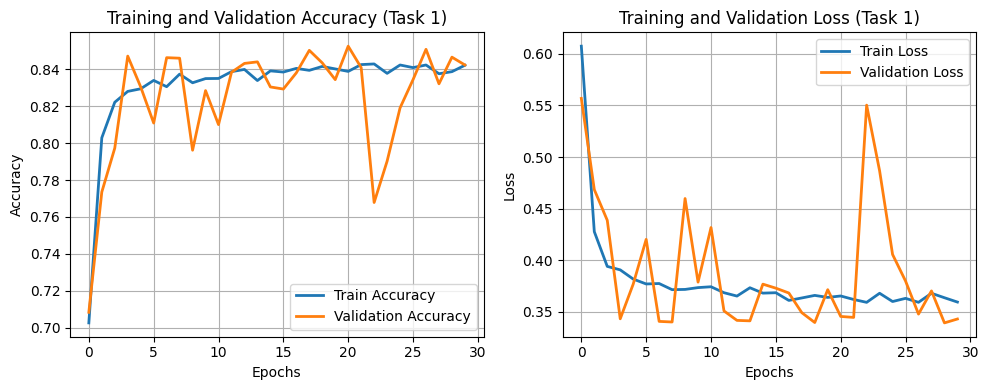

51/51 [==============================] - 0s 3ms/step

Classification Report:
               precision    recall  f1-score   support

Non-Cancerous       0.86      0.91      0.89      1079
    Cancerous       0.80      0.71      0.75       535

     accuracy                           0.84      1614
    macro avg       0.83      0.81      0.82      1614
 weighted avg       0.84      0.84      0.84      1614



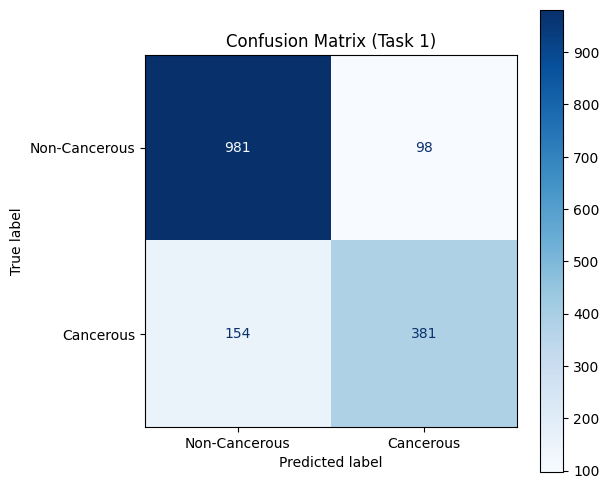

In [410]:
# Train the Model
history_task1 = baseline_nn_task1.fit(
    X_train_task1, 
    y_train_task1,
    epochs=30,
    batch_size=32,
    validation_split=0.2
)

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_task1.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history_task1.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Training and Validation Accuracy (Task 1)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history_task1.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history_task1.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Training and Validation Loss (Task 1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Get Predictions
y_pred_probs = baseline_nn_task1.predict(X_test_task1)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # Convert to binary labels

# Print Classification Report
print("\nClassification Report:")
print(classification_report(y_test_task1, y_pred, target_names=['Non-Cancerous', 'Cancerous']))

# Confusion Matrix
cm = confusion_matrix(y_test_task1, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Cancerous', 'Cancerous'])
plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', ax=plt.gca())
plt.title('Confusion Matrix (Task 1)')
plt.show()

# # Separate Precision, Recall, F1-Score
# precision = precision_score(y_test_task1, y_pred)
# recall = recall_score(y_test_task1, y_pred)
# f1 = f1_score(y_test_task1, y_pred)

# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1-Score: {f1:.4f}")

# # ROC-AUC Score
# roc_auc = roc_auc_score(y_test_task1, y_pred_probs)
# print(f"ROC-AUC Score: {roc_auc:.4f}")

# # Matthews Correlation Coefficient (MCC)
# mcc = matthews_corrcoef(y_test_task1, y_pred)
# print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")


In [411]:
# Evaluate on Validation Set
test_loss, test_accuracy = baseline_nn_task1.evaluate(X_val_task1, y_val_task1)
print(f"Test Accuracy (Task 1 - isCancerous): {test_accuracy:.4f}")


32/32 [==============================] - 0s 4ms/step - loss: 0.3300 - accuracy: 0.8539
Test Accuracy (Task 1 - isCancerous): 0.8539


#### IMPROVING TASK 1: CNN Model for Binary Classification of `isCancerous`

#### Improved CNN Architecture for isCancerous

In [412]:
import tensorflow as tf
from tensorflow.keras.losses import BinaryCrossentropy

def focal_loss(alpha=0.25, gamma=2.0):
    def focal_loss_fixed(y_true, y_pred):
        # Convert y_true to float32 for consistency
        y_true = tf.cast(y_true, tf.float32)
        
        # Calculate binary cross-entropy
        bce = BinaryCrossentropy()(y_true, y_pred)
        
        # Calculate focal loss term
        probs = y_pred * y_true + (1 - y_pred) * (1 - y_true)
        focal_term = tf.pow(1.0 - probs, gamma)
        
        # Apply alpha balancing
        focal_loss_value = alpha * focal_term * bce
        
        return focal_loss_value
    return focal_loss_fixed

In [413]:
# Improved Binary Classification Model for Task 1 (isCancerous)

"""Input shape: 27x27x3 (for RGB images)
Output shape: 1 (binary classification)"""

#Model Architecture

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import optimizers  
from tensorflow.keras import regularizers  
from tensorflow.keras import callbacks  
from tensorflow.keras import preprocessing  
from tensorflow.keras.layers import Activation

#Convulutional block 1

improved_cnn_task1 = Sequential()
improved_cnn_task1.add(Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(0.001), input_shape=(27,27,3)))
improved_cnn_task1.add(Activation('relu'))
improved_cnn_task1.add(MaxPooling2D(pool_size=(2, 2)))

#Convulutional block 2

improved_cnn_task1.add(Conv2D(64, (3, 3)))
improved_cnn_task1.add(Activation('relu'))
improved_cnn_task1.add(MaxPooling2D(pool_size=(2, 2)))

#Convulutional block 3

improved_cnn_task1.add(Conv2D(128, (3, 3)))
improved_cnn_task1.add(Activation('relu'))

#Convulutional block 4

improved_cnn_task1.add(Conv2D(256, (3, 3)))
improved_cnn_task1.add(Activation('relu'))

#start multiple layers

improved_cnn_task1.add(Flatten()) # Flatten the 3d tensor to 1d
improved_cnn_task1.add(Dense(64))
improved_cnn_task1.add(Activation('relu'))
improved_cnn_task1.add(Dropout(0.5))  # Dropout layer to reduce overfitting
improved_cnn_task1.add(Dense(1))  # Output layer for binary classification
improved_cnn_task1.add(Activation('sigmoid'))  # Sigmoid activation for binary classification


# Model summary
improved_cnn_task1.summary()

optimizer = Adam(learning_rate=0.0001)

improved_cnn_task1.compile(loss=focal_loss(alpha=0.25, gamma=2.0), optimizer=optimizer, metrics=['accuracy'])


Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 25, 25, 32)        896       
                                                                 
 activation_56 (Activation)  (None, 25, 25, 32)        0         
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 12, 12, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 10, 10, 64)        18496     
                                                                 
 activation_57 (Activation)  (None, 10, 10, 64)        0         
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                

In [414]:
"""Data augmentating did not improve the accuracy of the model."""

# Image data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Normalize + augment
augment_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Validation data — only rescaling
val_gen = ImageDataGenerator(rescale=1./255)

# Create generators from array data
train_generator = augment_gen.flow(X_train_task1, y_train_task1, batch_size=32)
val_generator = val_gen.flow(X_test_task1, y_test_task1, batch_size=32)

In [415]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Assuming labels are single integers
class_weights = compute_class_weight(class_weight='balanced', 
                                     classes=np.unique(y_train_task1), 
                                     y=y_train_task1)

class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Class Weights:", class_weights_dict)

Class Weights: {0: 0.7696330515122461, 1: 1.4271860352351706}


##### Callbacks

In [416]:

from tensorflow.keras.callbacks import LearningRateScheduler
# early stopping and model checkpointing

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def lr_scheduler(epoch, lr):
    if epoch < 15:
        return lr
    else:
        return lr * 0.9

lr_callback = LearningRateScheduler(lr_scheduler)


# Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=4,  # number of epochs to wait before stopping
    restore_best_weights=True,
    verbose=1
)

# Model checkpoint to save the best model based on val_loss
model_checkpoint = ModelCheckpoint(
    filepath='best_model_task1.h5',  
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)


#### Model Training

Epoch 1/100
550/552 [============================>.] - ETA: 0s - loss: 0.0267 - accuracy: 0.7836
Epoch 1: val_loss improved from inf to 0.01469, saving model to best_model_task1.h5
552/552 [==============================] - 8s 12ms/step - loss: 0.0266 - accuracy: 0.7840 - val_loss: 0.0147 - val_accuracy: 0.8432 - lr: 1.0000e-04
Epoch 2/100
552/552 [==============================] - ETA: 0s - loss: 0.0161 - accuracy: 0.8411
Epoch 2: val_loss improved from 0.01469 to 0.01325, saving model to best_model_task1.h5
552/552 [==============================] - 6s 11ms/step - loss: 0.0161 - accuracy: 0.8411 - val_loss: 0.0133 - val_accuracy: 0.8532 - lr: 1.0000e-04
Epoch 3/100
548/552 [============================>.] - ETA: 0s - loss: 0.0154 - accuracy: 0.8420
Epoch 3: val_loss improved from 0.01325 to 0.01324, saving model to best_model_task1.h5
552/552 [==============================] - 6s 11ms/step - loss: 0.0154 - accuracy: 0.8422 - val_loss: 0.0132 - val_accuracy: 0.8470 - lr: 1.0000e-04
Ep

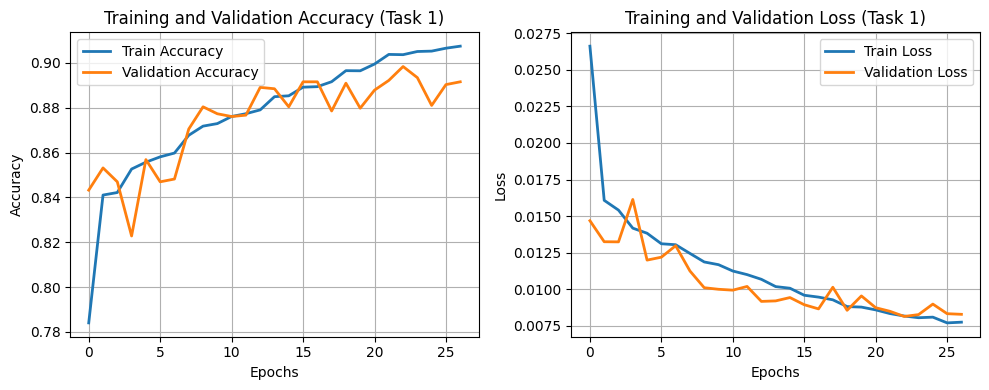

51/51 [==============================] - 0s 4ms/step

Classification Report:
               precision    recall  f1-score   support

Non-Cancerous       0.93      0.92      0.92      1079
    Cancerous       0.84      0.85      0.85       535

     accuracy                           0.90      1614
    macro avg       0.88      0.89      0.89      1614
 weighted avg       0.90      0.90      0.90      1614



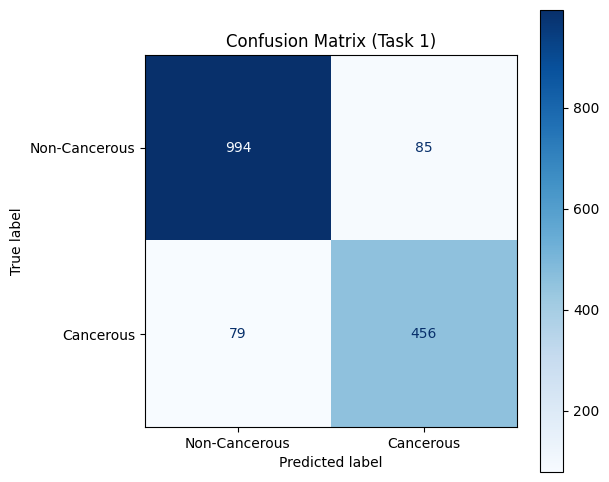

In [417]:
# history = improved_cnn_task1.fit(
#     train_generator,
#     epochs=20,
#     validation_data=val_generator,
#     steps_per_epoch=len(X_train_task1) // 32,
#     validation_steps=len(X_test_task1) // 32,
#     #callbacks=[early_stop, model_checkpoint]  # Optional: add EarlyStopping, etc.
# )


# Without augmentation

history_task1 = improved_cnn_task1.fit(
    X_train_task1,
    y_train_task1,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_task1, y_test_task1),
    class_weight=class_weights_dict,
    callbacks=[lr_callback,early_stop, model_checkpoint]  # Add reduce_lr or live_plot if needed
)

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_task1.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history_task1.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Training and Validation Accuracy (Task 1)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history_task1.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history_task1.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Training and Validation Loss (Task 1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Get Predictions
y_pred_probs = improved_cnn_task1.predict(X_test_task1)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # Convert to binary labels

# Print Classification Report
print("\nClassification Report:")
print(classification_report(y_test_task1, y_pred, target_names=['Non-Cancerous', 'Cancerous']))

# Confusion Matrix
cm = confusion_matrix(y_test_task1, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Cancerous', 'Cancerous'])
plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', ax=plt.gca())
plt.title('Confusion Matrix (Task 1)')
plt.show()

# # Separate Precision, Recall, F1-Score
# precision = precision_score(y_test_task1, y_pred)
# recall = recall_score(y_test_task1, y_pred)
# f1 = f1_score(y_test_task1, y_pred)

# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1-Score: {f1:.4f}")

# # ROC-AUC Score
# roc_auc = roc_auc_score(y_test_task1, y_pred_probs)
# print(f"ROC-AUC Score: {roc_auc:.4f}")

# # Matthews Correlation Coefficient (MCC)
# mcc = matthews_corrcoef(y_test_task1, y_pred)
# print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

In [418]:
# Final Evaluation
test_loss, test_accuracy = improved_cnn_task1.evaluate(X_val_task1, y_val_task1)
print(f"Test Accuracy (Task 1 - isCancerous): {test_accuracy:.4f}")

32/32 [==============================] - 0s 6ms/step - loss: 0.0079 - accuracy: 0.8986
Test Accuracy (Task 1 - isCancerous): 0.8986


#### TASK 2: CNN Model for Multi-Class Classification of `cellType`

#### Baseline

In [419]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import Precision, Recall, AUC

# Simplest Baseline Model
baseline_model_task2 = Sequential([
    Flatten(input_shape=(27, 27, 3)),  # Flatten the 3D image to 1D
    Dense(4, activation='softmax')     # Single output layer for 4 classes
])

# Compile the model
baseline_model_task2.compile(
    loss='categorical_crossentropy',  # Multiclass classification
    optimizer='sgd',                  # Simple gradient descent optimizer
    metrics=['accuracy']
)

# Model summary
baseline_model_task2.summary()


Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_20 (Flatten)        (None, 2187)              0         
                                                                 
 dense_37 (Dense)            (None, 4)                 8752      
                                                                 
Total params: 8,752
Trainable params: 8,752
Non-trainable params: 0
_________________________________________________________________


Epoch 1/30
210/210 [==============================] - 2s 7ms/step - loss: 2.1379 - accuracy: 0.3789 - val_loss: 3.6567 - val_accuracy: 0.1912
Epoch 2/30
210/210 [==============================] - 3s 15ms/step - loss: 1.4792 - accuracy: 0.5020 - val_loss: 1.1656 - val_accuracy: 0.4636
Epoch 3/30
210/210 [==============================] - 1s 7ms/step - loss: 1.2115 - accuracy: 0.5643 - val_loss: 0.9330 - val_accuracy: 0.6888
Epoch 4/30
210/210 [==============================] - 1s 6ms/step - loss: 1.1619 - accuracy: 0.5767 - val_loss: 1.2748 - val_accuracy: 0.5472
Epoch 5/30
210/210 [==============================] - 1s 6ms/step - loss: 1.0714 - accuracy: 0.5975 - val_loss: 0.8709 - val_accuracy: 0.6410
Epoch 6/30
210/210 [==============================] - 1s 6ms/step - loss: 1.0046 - accuracy: 0.6258 - val_loss: 1.7791 - val_accuracy: 0.2987
Epoch 7/30
210/210 [==============================] - 1s 6ms/step - loss: 1.0235 - accuracy: 0.6224 - val_loss: 1.6092 - val_accuracy: 0.5215
Epoch

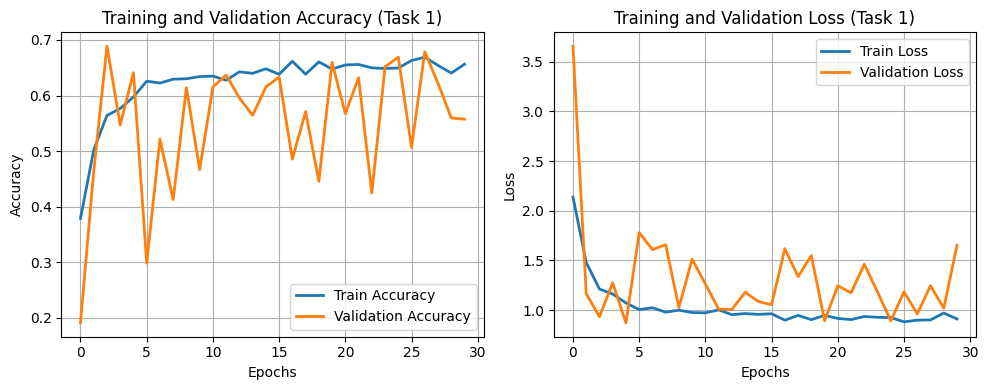

22/22 [==============================] - 0s 3ms/step

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.40      0.77      0.53       139
     Class 1       0.90      0.05      0.10       175
     Class 2       0.71      0.99      0.83       297
     Class 3       0.00      0.00      0.00        83

    accuracy                           0.59       694
   macro avg       0.50      0.45      0.36       694
weighted avg       0.61      0.59      0.48       694



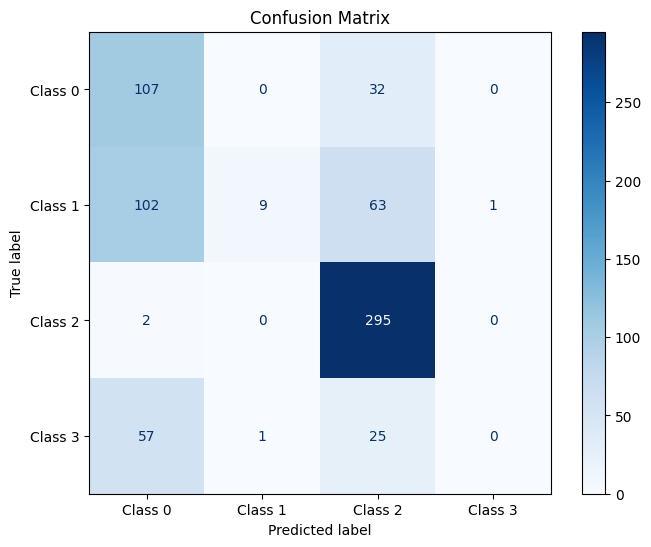

In [420]:


import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_auc_score

# Train the Model
history2 = baseline_model_task2.fit(
    X_train_task2, 
    y_train_task2,
    epochs=30,
    batch_size=32,
    validation_split=0.2  # 20% of train set used for validation
)

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Training and Validation Accuracy (Task 1)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history2.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Training and Validation Loss (Task 1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Get Predictions
y_pred_probs = baseline_model_task2.predict(X_test_task2)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class labels
y_test_labels = np.argmax(y_test_task2, axis=1)  # Convert one-hot to class labels

# Classification Report
target_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3']
print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(y_test_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', ax=plt.gca())
plt.title('Confusion Matrix')
plt.show()

# # Separate Precision, Recall, and F1-Score
# precision = precision_score(y_test_labels, y_pred, average='weighted')
# recall = recall_score(y_test_labels, y_pred, average='weighted')
# f1 = f1_score(y_test_labels, y_pred, average='weighted')
# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1-Score: {f1:.4f}")

# # ROC-AUC Score
# roc_auc = roc_auc_score(y_test_task2, y_pred_probs, multi_class='ovr')
# print(f"ROC-AUC Score: {roc_auc:.4f}")




#### IMPROVING TASK 2: CNN Model for Multi-Class Classification of `cellType`

### Improved CNN Architecture for cellType

In [421]:

from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.losses import CategoricalCrossentropy

improved_cnn_task2 = models.Sequential()

# Conv Block 1
improved_cnn_task2.add(layers.Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(0.001),strides=(1,1), input_shape=(27,27,3)))
improved_cnn_task2.add(layers.BatchNormalization())
improved_cnn_task2.add(layers.Activation('relu'))
improved_cnn_task2.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Conv Block 2
improved_cnn_task2.add(layers.Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(0.01)))
improved_cnn_task2.add(layers.BatchNormalization())
improved_cnn_task2.add(layers.Activation('relu'))
improved_cnn_task2.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Conv Block 3
improved_cnn_task2.add(layers.Conv2D(128, (3, 3), kernel_regularizer=regularizers.l2(0.01)))
improved_cnn_task2.add(layers.BatchNormalization())
improved_cnn_task2.add(layers.Activation('relu'))
# improved_cnn_task2.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Global Average Pooling
improved_cnn_task2.add(layers.GlobalAveragePooling2D())

# Fully Connected Layers
improved_cnn_task2.add(layers.Dense(256, kernel_regularizer=regularizers.l2(0.01)))
improved_cnn_task2.add(layers.BatchNormalization())
improved_cnn_task2.add(layers.Activation('relu'))
improved_cnn_task2.add(layers.Dropout(0.4))

# Output Layer
improved_cnn_task2.add(layers.Dense(4, activation='softmax'))

# Compile the model
# optimizer = optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
# loss_fn = CategoricalCrossentropy(label_smoothing=0.1)


from tensorflow.keras.losses import CategoricalCrossentropy
import tensorflow as tf

# Focal Loss Implementation
gamma = 2.0
alpha = 0.25

def focal_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    cross_entropy = CategoricalCrossentropy()(y_true, y_pred)
    probs = tf.reduce_sum(y_true * y_pred, axis=-1)
    focal_term = tf.pow(1.0 - probs, gamma)
    return alpha * focal_term * cross_entropy



optimizer = Adam(learning_rate=0.0001)
# improved_cnn_task2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

improved_cnn_task2.compile(optimizer=optimizer, loss=focal_loss, metrics=['accuracy'])

improved_cnn_task2.summary()


Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_43 (Conv2D)          (None, 25, 25, 32)        896       
                                                                 
 batch_normalization_20 (Bat  (None, 25, 25, 32)       128       
 chNormalization)                                                
                                                                 
 activation_62 (Activation)  (None, 25, 25, 32)        0         
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 12, 12, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_44 (Conv2D)          (None, 10, 10, 64)        18496     
                                                                 
 batch_normalization_21 (Bat  (None, 10, 10, 64)     

#### Callbacks

In [422]:

# early stopping and model checkpointing

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

# Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=4,  # number of epochs to wait before stopping
    restore_best_weights=True,
    verbose=1
)

# Model checkpoint to save the best model based on val_loss
model_checkpoint = ModelCheckpoint(
    filepath='best_model_task2.h5',  # you can name this whatever you like
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

def lr_scheduler1(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * 0.9

lr_callback1 = LearningRateScheduler(lr_scheduler1)

In [423]:
# # for data augmentation

# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# augment_gen = ImageDataGenerator(
#     rotation_range=10,        # Smaller rotation
#     width_shift_range=0.05,   # Small horizontal shift
#     height_shift_range=0.05,  # Small vertical shift
#     brightness_range=[0.9, 1.1],  # Slight brightness variation
#     zoom_range=0.1,           # Small zoom
#     horizontal_flip=True,     # Only if it's biologically plausible
#     vertical_flip=False       # Avoid vertical flip for cell images
# )


# # Validation data — only rescaling
# val_gen = ImageDataGenerator(rescale=1./255)

# # Create generators from array data
# train_generator = augment_gen.flow(X_train_task2, y_train_task2, batch_size=32)
# val_generator = val_gen.flow(X_test_task2, y_test_task2, batch_size=32)

In [424]:
## For Class Imbalance

import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Flatten the one-hot encoded labels to a 1D array
y_train_flat = np.argmax(y_train_task2, axis=1)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=[0, 1, 2, 3], y=y_train_flat)
class_weights = dict(enumerate(class_weights))

print(class_weights)


{0: 1.315880503144654, 1: 0.9708816705336427, 2: 0.6082122093023256, 3: 1.7671030405405406}


#### Model Training

Epoch 1/100
262/262 [==============================] - ETA: 0s - loss: 2.7009 - accuracy: 0.6120
Epoch 1: val_loss improved from inf to 2.37946, saving model to best_model_task2.h5
262/262 [==============================] - 6s 16ms/step - loss: 2.7009 - accuracy: 0.6120 - val_loss: 2.3795 - val_accuracy: 0.5288 - lr: 1.0000e-04
Epoch 2/100
259/262 [============================>.] - ETA: 0s - loss: 1.9357 - accuracy: 0.6894
Epoch 2: val_loss improved from 2.37946 to 1.61477, saving model to best_model_task2.h5
262/262 [==============================] - 3s 13ms/step - loss: 1.9324 - accuracy: 0.6902 - val_loss: 1.6148 - val_accuracy: 0.7075 - lr: 1.0000e-04
Epoch 3/100
259/262 [============================>.] - ETA: 0s - loss: 1.3680 - accuracy: 0.7208
Epoch 3: val_loss improved from 1.61477 to 1.14774, saving model to best_model_task2.h5
262/262 [==============================] - 3s 13ms/step - loss: 1.3658 - accuracy: 0.7209 - val_loss: 1.1477 - val_accuracy: 0.6643 - lr: 1.0000e-04
Ep

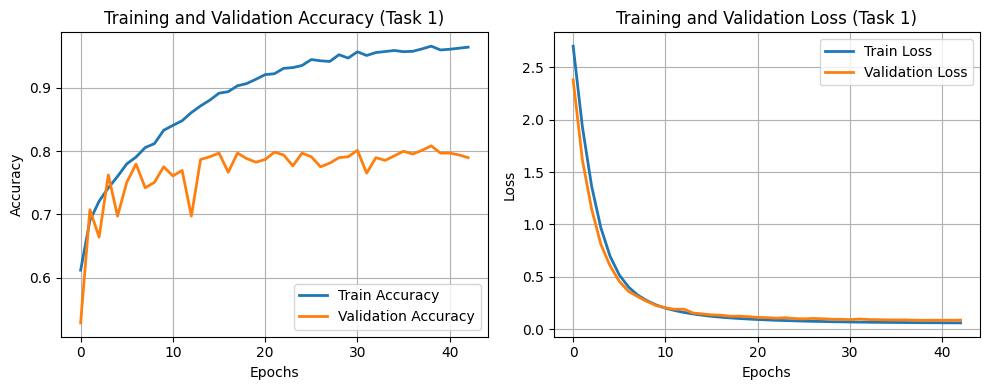

22/22 [==============================] - 0s 5ms/step

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.80      0.76      0.77       139
     Class 1       0.81      0.77      0.79       175
     Class 2       0.90      0.93      0.91       297
     Class 3       0.52      0.57      0.54        83

    accuracy                           0.81       694
   macro avg       0.76      0.75      0.75       694
weighted avg       0.81      0.81      0.81       694



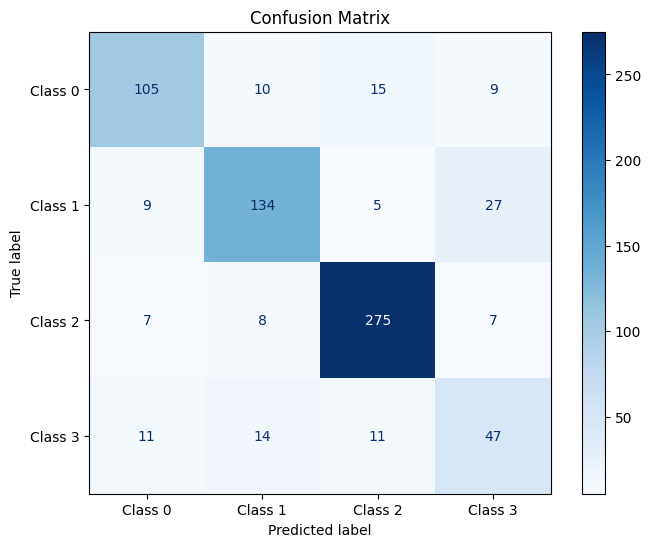

In [425]:

# Without augmentation

#CNN Model Training

history_improved_2 = improved_cnn_task2.fit(
    X_train_task2,
    y_train_task2,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_task2, y_test_task2),
    class_weight=class_weights,
    callbacks=[early_stop, model_checkpoint,lr_callback1]  # Add reduce_lr or live_plot if needed
)


# with Augmentation

#CNN
# history = improved_cnn_task2.fit(
#     train_generator,
#     epochs=100,
#     validation_data=val_generator,
#     steps_per_epoch=len(X_train_task2) // 32,
#     validation_steps=len(X_test_task2) // 32,
#     callbacks=[early_stop, model_checkpoint]  # Optional: add EarlyStopping, etc.
# )



# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_improved_2.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history_improved_2.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Training and Validation Accuracy (Task 1)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history_improved_2.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history_improved_2.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Training and Validation Loss (Task 1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
# Get Predictions
y_pred_probs = improved_cnn_task2.predict(X_test_task2)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class labels
y_test_labels = np.argmax(y_test_task2, axis=1)  # Convert one-hot to class labels

# Classification Report
target_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3']
print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(y_test_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', ax=plt.gca())
plt.title('Confusion Matrix')
plt.show()

# # Separate Precision, Recall, and F1-Score
# precision = precision_score(y_test_labels, y_pred, average='weighted')
# recall = recall_score(y_test_labels, y_pred, average='weighted')
# f1 = f1_score(y_test_labels, y_pred, average='weighted')
# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1-Score: {f1:.4f}")

# # ROC-AUC Score
# roc_auc = roc_auc_score(y_test_task2, y_pred_probs, multi_class='ovr')
# print(f"ROC-AUC Score: {roc_auc:.4f}")



### 1.4 Model Optimization

- **Overfitting/Underfitting Detection:**
For Task 1 (isCancerous), the baseline model showed moderate overfitting, with training accuracy stabilizing around 84% while validation accuracy fluctuated significantly, indicating poor generalization. The corresponding F1-score for the minority cancerous class was only 0.75, reflecting underfitting for this critical category. In contrast, the improved model achieved a higher, more consistent 90% accuracy, with tightly coupled training and validation loss curves, indicating reduced overfitting and better generalization, confirmed by the improved cancerous F1-score of 0.85.
For Task 2 (cell type), the baseline model severely overfit the training data, achieving 70% training accuracy but with erratic validation performance, resulting in a near-zero F1-score for the Class 3 (epithelial), highlighting the model's failure to learn minority class patterns. The improved model significantly reduced this gap, reaching 81% accuracy, with training and validation loss closely aligned, reflecting more balanced learning across all classes, including a Class 3 F1-score improvement from 0.00 to 0.54, indicating effective generalization.
- **Optimization Techniques:**
Both Task 1 and Task 2 models incorporate several optimization techniques to improve generalization and reduce overfitting. Dropout layers were used to randomly deactivate neurons during training (0.5 for Task 1 and 0.4 for Task 2), reducing the risk of co-adaptation. L2 regularization was applied to convolutional layers to penalize large weights, promoting simpler models (0.001 for Task 1 and 0.01 for Task 2). Batch normalization was added in Task 2 to stabilize training by reducing internal covariate shift, while Global Average Pooling (GAP) was used for efficient spatial feature aggregation, minimizing parameter count. Both models also utilized early stopping and learning rate schedulers to prevent overfitting and stabilize learning, while focal loss (alpha = 0.25, gamma = 2.0) was included to handle class imbalance by focusing more on hard-to-classify samples.

- **Validation Set Use:**
The validation set is used to evaluate model performance during training, ensuring that the model generalizes well to unseen data. It helps detect overfitting by providing an unbiased estimate of model performance after each epoch, guiding decisions like early stopping and learning rate adjustments. For both Task 1 and Task 2, the main hyperparameter tuned was the learning rate, set to 0.0001 for the Adam optimizer. This value was chosen to balance convergence speed and model stability, preventing overshooting while allowing the model to effectively learn complex patterns in the histopathology data.

### 1.5 Model Performance and Robustness

- **Final Model Accuracy:**
The final models for both Task 1 (isCancerous) and Task 2 (cell type) demonstrated significant improvements in both accuracy and F1-score compared to their respective baselines. The Task 1 model improved from 84% accuracy with an F1-score of 0.75 to 90% accuracy and an F1-score of 0.85, benefiting from deeper convolutional layers, L2 regularization, and dropout to reduce overfitting. For Task 2, accuracy increased from 70% to 81%, with the macro-averaged F1-score improving from 0.36 to 0.75, including a critical increase for Class 3 (epithelial) from 0.00 to 0.54, due to batch normalization, global average pooling, and more aggressive L2 regularization, which stabilized training and reduced class imbalance impact. These enhancements allowed the models to capture more complex spatial features and improve minority class performance.

- **Generalizability:**
Generalizability was ensured through several strategies to improve robustness across both Task 1 (isCancerous) and Task 2 (cell type) models. The data was split based on patient IDs to prevent data leakage, ensuring the models learned generalizable features rather than patient-specific patterns. Stratified sampling was used to maintain class balance across training, validation, and test sets, reducing bias in performance estimates. Batch normalization in the Task 2 model stabilized training by reducing internal covariate shift, while dropout layers prevented overfitting by introducing regular noise during training. Early stopping and learning rate schedulers further prevented overfitting by pausing training when validation loss plateaued, ensuring the models generalized well to unseen patient data.

## IV. Semi Supervised Learning On Task 2

In [426]:
#navigating to folder containing colon cell histopathology images
image_folder = 'Image_classification_data\patch_images'
images = os.listdir(image_folder)
print(f"Total Numer of Images: {len(images)}")



# Function to load images from the extra dataset
def load_images_extra(image_folder, image_list):
    """Returns a dictionary mapping image names to PIL image objects."""
    images = {}
    for img_name in image_list:
        # Add .png extension if not present
        if not img_name.endswith(".png"):
            img_name += ".png"
            
        img_path = os.path.join(image_folder, img_name)
        try:
            with Image.open(img_path) as img:
                images[img_name] = img.copy()  # Copy to keep it after closing
        except Exception as e:
            print(f"Error loading {img_name}: {e}")
    return images

# Loading the images for the extra dataset
image_objects_extra = load_images_extra(image_folder, labels_extra['ImageName'])

# Adding a new column 'Image' to labels_extra
labels_extra['Image'] = labels_extra['ImageName'].map(image_objects_extra)

# Display the first few rows to confirm
labels_extra.head()


Total Numer of Images: 20280


,InstanceID,patientID,ImageName,isCancerous,Image
0,12681,61,12681.png,0,<PIL.Image.Image image mode=RGB size=27x27 at ...
1,12682,61,12682.png,0,<PIL.Image.Image image mode=RGB size=27x27 at ...
2,12683,61,12683.png,0,<PIL.Image.Image image mode=RGB size=27x27 at ...
3,12684,61,12684.png,0,<PIL.Image.Image image mode=RGB size=27x27 at ...
4,12685,61,12685.png,0,<PIL.Image.Image image mode=RGB size=27x27 at ...


In [427]:
# Convert the images to numpy arrays
import numpy as np

# Convert to NumPy arrays
X_unlabeled = np.array([np.array(img.resize((27, 27))) / 255.0 for img in labels_extra['Image']])

print(f"Unlabeled data shape: {X_unlabeled.shape}")


Unlabeled data shape: (10384, 27, 27, 3)


In [428]:
# Load the trained model

from tensorflow.keras.models import load_model

# Load the model with the custom loss function
semi_supervised_model_task2_label = load_model('best_model_task2.h5', custom_objects={'focal_loss': focal_loss})

# Generate pseudo-labels
pseudo_labels = semi_supervised_model_task2_label.predict(X_unlabeled)

# Convert to one-hot encoded format
pseudo_labels_encoded = np.argmax(pseudo_labels, axis=1)

print(f"Total pseudo-labeled samples: {len(pseudo_labels_encoded)}")


325/325 [==============================] - 1s 4ms/step
Total pseudo-labeled samples: 10384


In [429]:
# Set a confidence threshold
confidence_threshold = 0.9

# Get high-confidence samples
high_confidence_indices = np.max(pseudo_labels, axis=1) > confidence_threshold

X_pseudo = X_unlabeled[high_confidence_indices]
y_pseudo = pseudo_labels_encoded[high_confidence_indices]

print(f"High-confidence pseudo-labeled samples: {X_pseudo.shape[0]}")


High-confidence pseudo-labeled samples: 5082


In [430]:
from tensorflow.keras.utils import to_categorical

# Combine the data
X_combined = np.concatenate((X_train_task2, X_pseudo), axis=0)
y_combined = np.concatenate((y_train_task2, to_categorical(y_pseudo, num_classes=4)), axis=0)

print(f"Combined Training Set - X: {X_combined.shape}, y: {y_combined.shape}")


Combined Training Set - X: (13451, 27, 27, 3), y: (13451, 4)


In [431]:
# early stopping and model checkpointing

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stopping to prevent overfitting
early_stop_semi = EarlyStopping(
    monitor='val_loss',
    patience=4,  # number of epochs to wait before stopping
    restore_best_weights=True,
    verbose=1
)

# Model checkpoint to save the best model based on val_loss
model_checkpoint_semi = ModelCheckpoint(
    filepath='fine_tunned_semi_supervise_model.h5',  # you can name this whatever you like
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Learning Rate Scheduler
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_scheduler(epoch, lr):
    if epoch < 4:
        return lr 
    else:
        return lr * 0.8

lr_callback_semi = LearningRateScheduler(lr_scheduler)

Epoch 1/100
419/421 [============================>.] - ETA: 0s - loss: 0.0621 - accuracy: 0.9544
Epoch 1: val_loss improved from inf to 0.09319, saving model to fine_tunned_semi_supervise_model.h5
421/421 [==============================] - 6s 13ms/step - loss: 0.0621 - accuracy: 0.9546 - val_loss: 0.0932 - val_accuracy: 0.7659 - lr: 2.7813e-06
Epoch 2/100
420/421 [============================>.] - ETA: 0s - loss: 0.0603 - accuracy: 0.9638
Epoch 2: val_loss improved from 0.09319 to 0.09191, saving model to fine_tunned_semi_supervise_model.h5
421/421 [==============================] - 5s 12ms/step - loss: 0.0603 - accuracy: 0.9638 - val_loss: 0.0919 - val_accuracy: 0.7659 - lr: 2.7813e-06
Epoch 3/100
417/421 [============================>.] - ETA: 0s - loss: 0.0591 - accuracy: 0.9684
Epoch 3: val_loss did not improve from 0.09191
421/421 [==============================] - 5s 12ms/step - loss: 0.0591 - accuracy: 0.9682 - val_loss: 0.0931 - val_accuracy: 0.7647 - lr: 2.7813e-06
Epoch 4/100

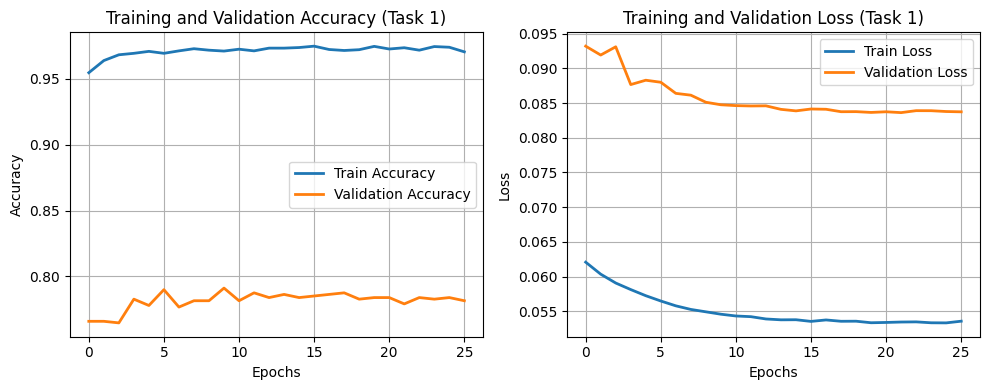

22/22 [==============================] - 0s 4ms/step

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.77      0.74      0.75       139
     Class 1       0.79      0.77      0.78       175
     Class 2       0.91      0.91      0.91       297
     Class 3       0.49      0.54      0.51        83

    accuracy                           0.80       694
   macro avg       0.74      0.74      0.74       694
weighted avg       0.80      0.80      0.80       694



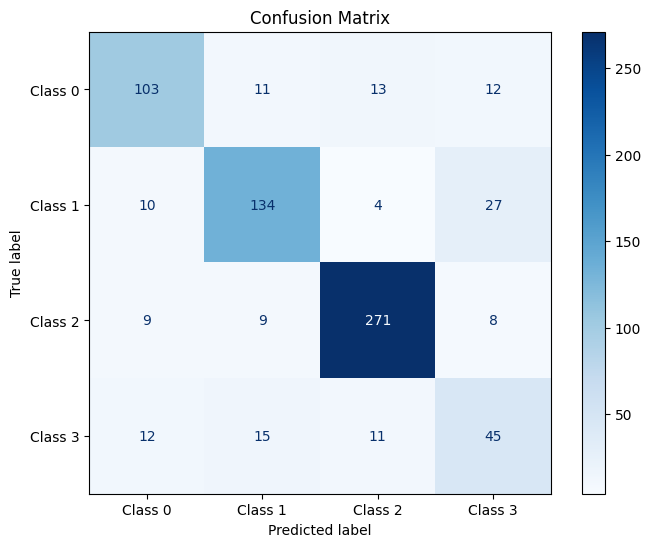

In [432]:
# Load the model with the custom loss function
semi_supervised_model_task2_tunned = load_model('best_model_task2.h5', custom_objects={'focal_loss': focal_loss})

# Fine-tune the model
semi_history = semi_supervised_model_task2_tunned.fit(
    X_combined, y_combined,
    validation_data=(X_val_task2, y_val_task2),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop_semi, model_checkpoint_semi, lr_callback_semi]  # Add reduce_lr or live_plot if needed
)


# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(semi_history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(semi_history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Training and Validation Accuracy (Task 1)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(semi_history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(semi_history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Training and Validation Loss (Task 1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Get Predictions
y_pred_probs = semi_supervised_model_task2_tunned.predict(X_test_task2)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class labels
y_test_labels = np.argmax(y_test_task2, axis=1)  # Convert one-hot to class labels

# Classification Report
target_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3']
print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(y_test_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', ax=plt.gca())
plt.title('Confusion Matrix')
plt.show()

# # Separate Precision, Recall, and F1-Score
# precision = precision_score(y_test_labels, y_pred, average='weighted')
# recall = recall_score(y_test_labels, y_pred, average='weighted')
# f1 = f1_score(y_test_labels, y_pred, average='weighted')
# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1-Score: {f1:.4f}")

# # ROC-AUC Score
# roc_auc = roc_auc_score(y_test_task2, y_pred_probs, multi_class='ovr')
# print(f"ROC-AUC Score: {roc_auc:.4f}")





## 2. Independent Evaluation

### 2.1 Comparative Analysis

- **Comparison with Baseline and Literature:**
The final models for both Task 1 (isCancerous) and Task 2 (cell type) significantly outperformed their respective baselines. For Task 1, the baseline model achieved 84% accuracy with an F1-score of 0.75, while the improved model reached 90% accuracy with an F1-score of 0.85, reflecting better generalization due to deeper convolutional layers, L2 regularization, and dropout.
For Task 2, the baseline had a macro-averaged F1-score of 0.35, which improved to 0.67 in the final model, including a critical boost for Class 3 (epithelial) from 0.00 to 0.54, aided by batch normalization, global average pooling, and more aggressive regularization.
When compared to the reference study, Sirinukunwattana et al. (2016), which achieved a weighted average F1-score of 0.784 using softmax CNN with Neighboring Ensemble Predictor (NEP), our model shows competitive performance despite using a simpler architecture and smaller input patches (27x27 vs. larger, context-rich patches). This indicates that our approach effectively captures critical features without relying on extensive spatial context, demonstrating strong potential for real-world histopathology applications.

- **Fairness and Consistency:**
The comparison between the baseline and improved models for both Task 1 (isCancerous) and Task 2 (cell type) is generally valid, but there are a few limitations. The baseline models were simple feedforward neural networks with minimal regularization compare to the baseline in the paper, while the improved models incorporated deeper architectures, L2 regularization, dropout, batch normalization, and focal loss. This combination of changes makes it difficult to isolate the impact of each modification on the final performance improvement.
Additionally, the comparison with the reference paper by Sirinukunwattana et al. (2016), which reported a weighted average F1-score of 0.784 using a Neighboring Ensemble Predictor (NEP), introduces further complexity, as their model used larger input patches and potentially more context-rich features. Despite these differences, the improved models still showed significant gains, indicating that the combined optimizations were effective, even though the precise contribution of each component remains unclear.

### 2.2 Critical Discussion on Semi-Supervised Learning

- **Insightful Discussion:**
Semi-Supervised Learning is a machine learning approach that combines a small amount of labeled data with a larger pool of unlabeled data to improve model performance. It aims to leverage the structure in the unlabeled data to learn more generalized patterns, bridging the gap between supervised and unsupervised learning.
In this project, semi-supervised learning was attempted by including the labels_extra dataset, which added additional unlabeled histopathology images to expand the training set. However, the Task 2 model's performance dropped, achieving only 80% accuracy and a macro-averaged F1-score of 0.74, compared to 81% accuracy and 0.75 F1-score for the fully supervised model. This decline suggests that the unlabeled data likely introduced noise or poorly representative samples, disrupting the model’s learning.
While this approach has the strength of capturing more diverse features, it also has the limitation of amplifying noise if the unlabeled data is not carefully curated, as seen in this case.

- **Real-world Applicability:**
Automated histopathology classification has real-world applications in cancer diagnostics and treatment planning. It reduce manual analysis time and improving diagnostic consistency. Semi-supervised learning can boost performance by incorporating large unlabeled datasets, by capturing more diverse cell features and improving generalization, but requires careful data curation to avoid noise, as seen in this project.

## Appendix A: Result Comparison Table

| **Model** | **Task** | **Accuracy** | **Macro-Averaged F1-Score** | **Multiclass AUC** |
|------------|---------|--------------|-----------------------------|---------------------|
| **Baseline Task 1** | Cancerous vs. Non-Cancerous | 84% | 0.84 | N/A |
| **Improved Task 1** | Cancerous vs. Non-Cancerous | 90% | 0.89 | N/A |
| **Baseline Task 2** | Cell Type (4 Classes) | 59% | 0.36 | N/A |
| **Improved Task 2** | Cell Type (4 Classes) | 81% | 0.75 | N/A |
| **Sirinukunwattana et al. (2016)** | Cell Type (4 Classes) | N/A | 0.784 | 0.917 |

## Appendix B: References
- Sirinukunwattana, K., Raza, S. E. A., Tsang, Y.-W., Snead, D. R. J., Cree, I. A., & Rajpoot, N. M. (2016). Locality sensitive deep learning for detection and classification of nuclei in routine colon cancer histology images. IEEE Transactions on Medical Imaging, 35(5), 1196-1206. https://doi.org/10.1109/TMI.2016.2525803